# Imports

In [3]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [4]:
import tensorflow as tf
import os
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense, Input
import joblib
from sklearn.preprocessing import StandardScaler
from datetime import datetime
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.pipeline import Pipeline


In [5]:
TIMESTAMP = datetime.now().strftime("%d%m%Y%H%M%S")


In [6]:
# set working directory to project root
os.chdir("C:/Users/zacha/Documents/GitHub/plymouth-university-proj518")
print(os.getcwd())


C:\Users\zacha\Documents\GitHub\plymouth-university-proj518


In [7]:
!rmdir /S /Q "/logs/fit/" # clear logs

The system cannot find the path specified.
The system cannot find the file specified.
The system cannot find the file specified.


# Load GPU
* Utilise GPU acceleration.
* Training takes approx. 2 hours using single 1060ti.

In [8]:
gpus = tf.config.list_physical_devices("GPU")
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.list_logical_devices("GPU")
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        print(e)


1 Physical GPUs, 1 Logical GPUs


# Load dataset
* Apply standard scaling to target features.
* Generate 80/10/10 training/test/validation split.

In [9]:
# load dataset
file = "data/NCEP daily velocity potential reanalysis.csv"
df = pd.read_csv(file, sep=",")

yscaler = StandardScaler()
yscaler.fit(df[["Chi"]])
df[["Chi"]] = yscaler.transform(df[["Chi"]])

# split into train and test sets (80/10/10, with train being sampled in training for validation)
train_x, test_x, train_y, test_y = train_test_split(
    df[["Lon", "Lat", "Day"]], df[["Chi"]], test_size=0.1
)


# Define model
* 10 layer, ~840k parameter model.
* Dense network, experimentally defined.

In [10]:
def create_model():
    return Sequential(
        [
            Dense(32, input_dim=3, activation="relu"),
            Dense(64, activation="relu"),
            Dense(128, activation="relu"),
            Dense(256, activation="relu"),
            Dense(512, activation="relu"),
            Dense(1024, activation="relu"),
            Dense(128, activation="relu"),
            Dense(64, activation="relu"),
            Dense(8, activation="relu"),
            Dense(1, activation="linear"),
        ]
    )


# Run model
* Compile the model, reducing MSE loss and optimising using the ADAM optimiser.
* Split 10% of training data for validation.
* Run for 200 epochs (expensive but experimentally produces good fitness).
* Evaluate on unseen test data to guage performance when upscaling.

In [11]:
# build model
model = create_model()

model.compile(loss="mse", optimizer="adam", metrics=["mse", "mae"])

log_dir = "logs/fit/" + TIMESTAMP
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

history = model.fit(
    train_x,
    train_y,
    validation_split=0.1,
    epochs=200,
    batch_size=1024,
    callbacks=[tensorboard_callback],
)


Epoch 1/200
3270/3270 [==============================] - 26s 8ms/step - loss: 0.2491 - mse: 0.2491 - mae: 0.3832 - val_loss: 0.1766 - val_mse: 0.1766 - val_mae: 0.3254
Epoch 2/200
3270/3270 [==============================] - 24s 7ms/step - loss: 0.1631 - mse: 0.1631 - mae: 0.3131 - val_loss: 0.1496 - val_mse: 0.1496 - val_mae: 0.2992
Epoch 3/200
3270/3270 [==============================] - 25s 8ms/step - loss: 0.1472 - mse: 0.1472 - mae: 0.2962 - val_loss: 0.1440 - val_mse: 0.1440 - val_mae: 0.2930
Epoch 4/200
3270/3270 [==============================] - 25s 7ms/step - loss: 0.1352 - mse: 0.1352 - mae: 0.2826 - val_loss: 0.1349 - val_mse: 0.1349 - val_mae: 0.2814
Epoch 5/200
3270/3270 [==============================] - 24s 7ms/step - loss: 0.1261 - mse: 0.1261 - mae: 0.2718 - val_loss: 0.1247 - val_mse: 0.1247 - val_mae: 0.2717
Epoch 6/200
3270/3270 [==============================] - 24s 7ms/step - loss: 0.1186 - mse: 0.1186 - mae: 0.2629 - val_loss: 0.1171 - val_mse: 0.1171 - val_mae:

In [12]:
# Evaluate the model on the test data using `evaluate`
print("Evaluate on test data")
results = model.evaluate(test_x, test_y, batch_size=128)
print("test loss, test acc:", results)

# Generate predictions (probabilities -- the output of the last layer)
# on new data using `predict`
print("Generate predictions for 3 samples")
predictions = model.predict(test_x[:3])
print("predictions shape:", predictions.shape)


Evaluate on test data
3229/3229 [==============================] - 6s 2ms/step - loss: 0.0255 - mse: 0.0255 - mae: 0.1186
test loss, test acc: [0.02546338550746441, 0.02546338550746441, 0.11860799044370651]
Generate predictions for 3 samples
predictions shape: (3, 1)


# Visualisation
* Plot model loss over time, improving during training.

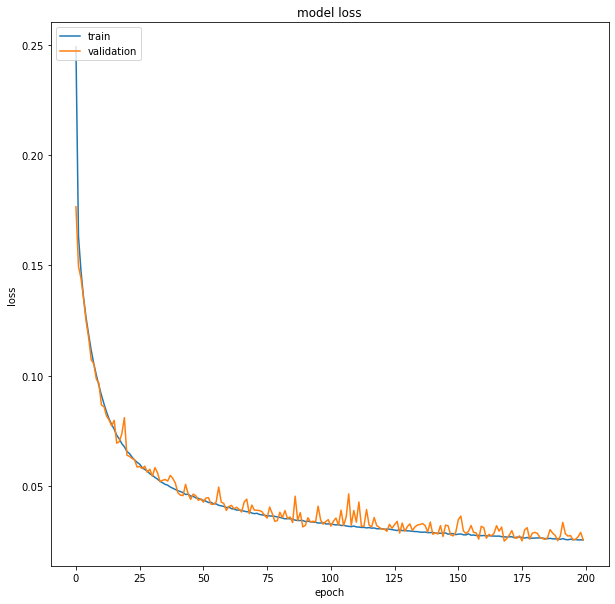

In [13]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)

plt.title("model loss")

ax.plot(history.history["loss"])
ax.plot(history.history["val_loss"])

plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train", "validation"], loc="upper left")

fig.savefig("exported/wind_time_regression_loss.png")
plt.show()


# Tensorboard
* Load a local tensorboard session to view logs.
* Example: https://tensorboard.dev/experiment/cY462dBbSrSJopeV2KQG7A/# 

In [14]:
%tensorboard --logdir logs/fit

Reusing TensorBoard on port 6006 (pid 11508), started 1 day, 0:55:33 ago. (Use '!kill 11508' to kill it.)

# Test
* Mirror dataset Chi values with predicted values.

In [15]:
from mpl_toolkits.basemap import Basemap
import loadingbar
import matplotlib.animation as animation


In [48]:
def mirror(model, df, yscaler):
    pred_df = df.copy()

    pred = model.predict(pred_df)  # batch predict using model

    pred = yscaler.inverse_transform(pred)  # transform back to original scale

    # join prediction with original dataframe
    pred_df["Chi"] = pred

    return pred_df


In [17]:
file = "data/NCEP daily velocity potential reanalysis.csv"
df = pd.read_csv(file, sep=",")


██████████████████████████████████████████████████0m0m0m0m0m0m0m0m0m0m0m0m0m0m0m0m0m0m0m0m0m0m0m0m0m0m0m0m0m0m0m0m0m0m0m0m0m0m0m0m0m0m0m0m0m0m0m0m


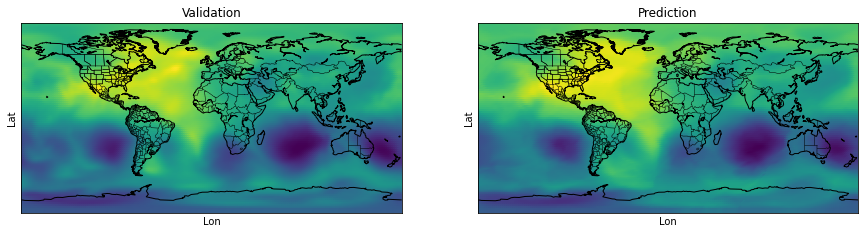

In [18]:
L = loadingbar.LoadingBar(df["Day"].max())

# create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 4))

df_day = df[df["Day"] == df["Day"].min()]
ax1.scatter(df_day["Lon"], df_day["Lat"], c=df_day["Chi"], cmap="viridis")

test_df = df_day.drop(columns=["Chi"])
wind_time_predicted = mirror(model, test_df, yscaler)
ax2.scatter(
    wind_time_predicted["Lon"],
    wind_time_predicted["Lat"],
    c=wind_time_predicted["Chi"],
    cmap="viridis",
)

ax1.set_xlabel("Lon")
ax1.set_ylabel("Lat")
ax1.set_title("Validation")

ax2.set_xlabel("Lon")
ax2.set_ylabel("Lat")
ax2.set_title("Prediction")

mp1 = Basemap(ax=ax1)
mp2 = Basemap(ax=ax2)


def update(i):
    L.update(1)

    if i > 228:
        i = 0

    ax1.clear()
    ax1.collections.clear()

    ax2.clear()
    ax2.collections.clear()

    df_day = df[df["Day"] == i]
    ax1.scatter(df_day["Lon"], df_day["Lat"], c=df_day["Chi"], cmap="viridis")
    mp1.drawcoastlines()
    mp1.drawstates()
    mp1.drawcountries()

    test_df = df_day.drop(columns=["Chi"])
    wind_time_predicted = mirror(model, test_df, yscaler)
    ax2.scatter(
        wind_time_predicted["Lon"],
        wind_time_predicted["Lat"],
        c=wind_time_predicted["Chi"],
        cmap="viridis",
    )
    mp2.drawcoastlines()
    mp2.drawstates()
    mp2.drawcountries()

    ax1.set_xlabel("Lon")
    ax1.set_ylabel("Lat")
    ax1.set_title("Validation")

    ax2.set_xlabel("Lon")
    ax2.set_ylabel("Lat")
    ax2.set_title("Prediction")


ani = animation.FuncAnimation(
    fig, update, frames=df["Day"].max(), interval=100, blit=False
)

test_gif_path = os.path.join(
    os.getcwd(),
    "saved_models",
    f"wind_time_regression_model_test_{TIMESTAMP}.gif",
)
ani.save(test_gif_path, writer="imagemagick")

L.done()


# Upscale
* Add subsample points between known dataset longitudes/latitudes, generating a map with 2x resolution.

██████████████████████████████████████████████████0m0m0m0m0m0m0m0m0m0m0m0m0m0m0m0m0m0m0m0m0m0m0m0m0m0m0m0m0m0m0m0m0m0m0m0m0m0m0m0m0m0m0m0m0m0m0m0m


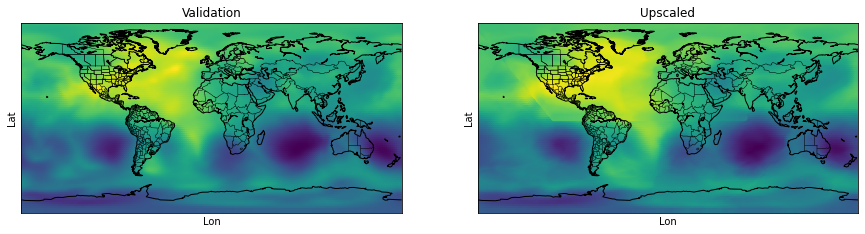

In [49]:
L = loadingbar.LoadingBar(df["Day"].max())

# get min day
today = df["Day"].min()

# get max day
max_day = df["Day"].max()

# get all unique lon lats
lonlat_df = df[df["Day"] == df["Day"].min()]
# drop chi
lonlat_df = lonlat_df.drop(columns=["Chi"])

# reset pred_df index
lonlat_df = lonlat_df.reset_index(drop=True)

# copy pred_df
test_df = lonlat_df.copy()

# add new data points halfway between each unique point
for i, row in lonlat_df.iterrows():
    if i == 0:
        continue

    # get previous row
    prev = df.iloc[i - 1]

    # calculate new lat and lon
    new_lat = (row["Lat"] + prev["Lat"]) / 2
    new_lon = (row["Lon"] + prev["Lon"]) / 2

    # add new row to dataframe
    test_df = test_df.append(
        {"Lat": new_lat, "Lon": new_lon, "Day": today}, ignore_index=True
    )

# create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 4))

df_day = df[df["Day"] == df["Day"].min()]
ax1.scatter(df_day["Lon"], df_day["Lat"], c=df_day["Chi"], cmap="viridis")

wind_time_predicted = mirror(model, test_df, yscaler)
ax2.scatter(
    wind_time_predicted["Lon"],
    wind_time_predicted["Lat"],
    c=wind_time_predicted["Chi"],
    cmap="viridis",
)

ax1.set_xlabel("Lon")
ax1.set_ylabel("Lat")
ax1.set_title("Validation")

ax2.set_xlabel("Lon")
ax2.set_ylabel("Lat")
ax2.set_title("Upscaled")

mp1 = Basemap(ax=ax1)
mp2 = Basemap(ax=ax2)


def update(i):
    L.update(1)

    if i > 228:
        i = 0

    ax1.clear()
    ax1.collections.clear()

    ax2.clear()
    ax2.collections.clear()

    df_day = df[df["Day"] == i]
    ax1.scatter(df_day["Lon"], df_day["Lat"], c=df_day["Chi"], cmap="viridis")
    mp1.drawcoastlines()
    mp1.drawstates()
    mp1.drawcountries()

    # set all days in test_df to current day
    test_df["Day"] = i
    wind_time_predicted = mirror(model, test_df, yscaler)
    ax2.scatter(
        wind_time_predicted["Lon"],
        wind_time_predicted["Lat"],
        c=wind_time_predicted["Chi"],
        cmap="viridis",
    )
    mp2.drawcoastlines()
    mp2.drawstates()
    mp2.drawcountries()

    ax1.set_xlabel("Lon")
    ax1.set_ylabel("Lat")
    ax1.set_title("Validation")

    ax2.set_xlabel("Lon")
    ax2.set_ylabel("Lat")
    ax2.set_title("Upscaled")


ani = animation.FuncAnimation(
    fig, update, frames=df["Day"].max(), interval=100, blit=False
)

test_gif_path = os.path.join(
    os.getcwd(),
    "saved_models",
    f"wind_time_regression_model_test_upscaled_{TIMESTAMP}.gif",
)
ani.save(test_gif_path, writer="imagemagick")

L.done()


# Export
* Save model and output scaler.

In [19]:
# save model and weights
model_path = os.path.join(
    os.getcwd(),
    "saved_models",
    f"wind_time_regression_model_{TIMESTAMP}.h5",
)
model.save(model_path)
print("Saved trained model at %s " % model_path)

scaler_path = os.path.join(
    os.getcwd(),
    "saved_models",
    f"wind_time_scaler_{TIMESTAMP}",
)
joblib.dump(yscaler, scaler_path)
print("Saved scaler at %s " % scaler_path)


Saved trained model at C:\Users\zacha\Documents\GitHub\plymouth-university-proj518\saved_models\wind_time_regression_model_25092022140946.h5 
Saved scaler at C:\Users\zacha\Documents\GitHub\plymouth-university-proj518\saved_models\wind_time_scaler_25092022140946 
